In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import os 
parent = os.path.dirname(os.getcwd())
parent = os.path.dirname(parent)

print(f"{parent = }")


import sys
if not parent in sys.path:
    sys.path.append(parent)

parent = '/lustre06/project/6067616/soroush1/WM_age_of_ultron'


In [8]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt

import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

Files already downloaded and verified


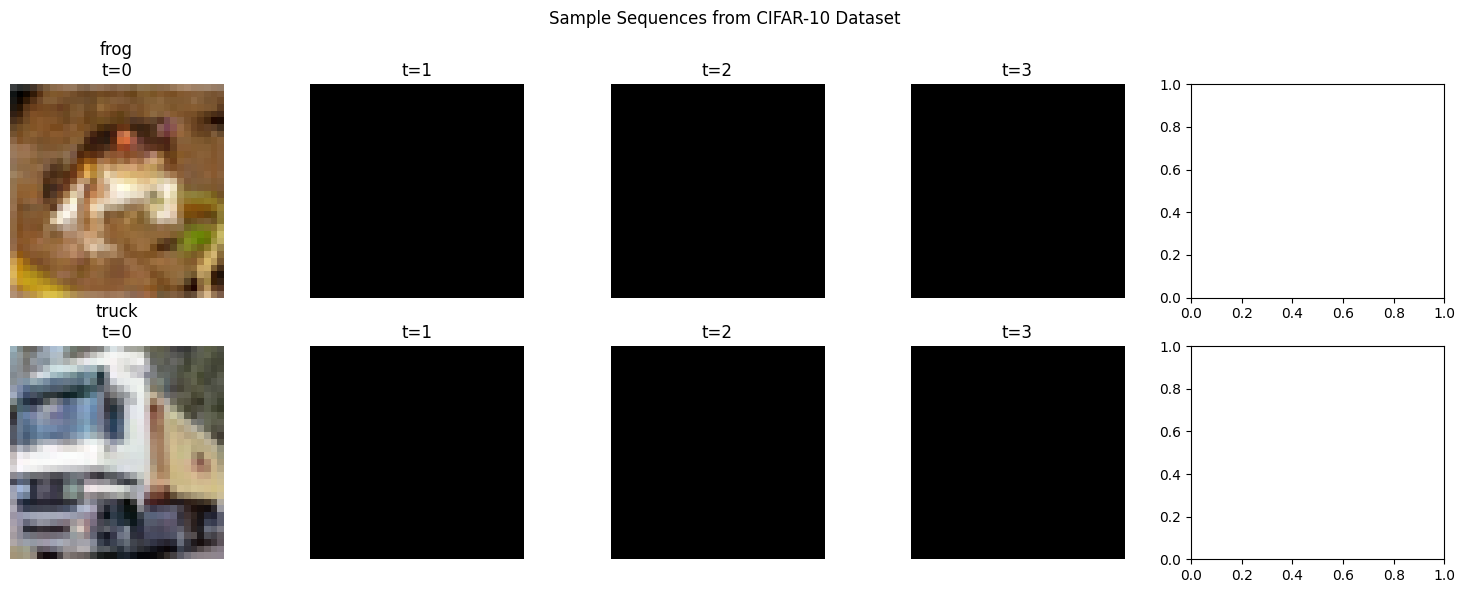

Dataset size: 50000
Sequence shape: torch.Size([4, 3, 32, 32])
Label shape: torch.Size([])
Batch sequences shape: torch.Size([32, 4, 3, 32, 32])
Batch labels shape: torch.Size([32])


In [9]:
class CIFAR10SequenceDataset(Dataset):
    def __init__(self, root, train=True, num_timesteps=5, transform=None):
        self.cifar = datasets.CIFAR10(root=root, train=train, download=True, transform=transform)
        self.num_timesteps = num_timesteps
        self.to_grayscale = transforms.Grayscale(3)  # 3-channel grayscale

    def __len__(self):
        return len(self.cifar)

    def __getitem__(self, idx):
        image, label = self.cifar[idx]
        
        # Create sequence: first frame is the original color image, rest are grayscale
        sequence = [image]
        labels = []
        for _ in range(self.num_timesteps - 1):
            gray_value = torch.rand(1).item()
            gray_frame = torch.full((3, 32, 32), gray_value)
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        return sequence, label

# Set up parameters
root = './data'
num_timesteps = 4
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Sequences from CIFAR-10 Dataset")

for i in range(2):
    sequence, label = dataset[i]
    class_name = dataset.cifar.classes[label]
    
    for t in range(num_timesteps):
        if t == 0:
            # For the first frame, use color
            axes[i, t].imshow(sequence[t].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        else:
            # For subsequent frames, use grayscale
            axes[i, t].imshow(sequence[t][0], cmap='gray')
        axes[i, t].axis('off')
        axes[i, t].set_title(f"{class_name}\nt={t}" if t == 0 else f"t={t}")

plt.tight_layout()
plt.show()

# Print shape information
print(f"Dataset size: {len(dataset)}")
print(f"Sequence shape: {sequence.shape}")
print(f"Label shape: {torch.tensor(label).shape}")

# Get a batch
batch_sequences, batch_labels = next(iter(dataloader))
print(f"Batch sequences shape: {batch_sequences.shape}")
print(f"Batch labels shape: {batch_labels.shape}")

# Summary of ResNetLSTM Model Development and Validation

## Initial Dataset and Model Setup
- Reviewed the CIfar class for generating sequences of images
- Examined the initial ResNetLSTM model architecture, combining ResNet50 and LSTM

## Fine-tuning ResNet50
- Created a script to fine-tune ResNet50 on the first frame (t=0) of the dataset
- Implemented training and validation loops
- Added code to save model weights and plot learning curves

## ResNetLSTM Model Updates
- Reviewed updates to the ResNetLSTM class, including:
  - Option to load fine-tuned weights
  - Modification of ResNet's first layer for 1-channel input
  - Detailed forward pass with optional verbose output

## Validation Script for ResNetLSTM
- Created a validation script for the updated ResNetLSTM model
- Incorporated the ability to load fine-tuned weights
- Implemented a validation loop to evaluate model performance
- Calculated and displayed validation accuracy

## Key Considerations
- Adapted the model and scripts to work with 1-channel input from the MovingShapesDataset
- Ensured proper loading of fine-tuned weights in the ResNetLSTM model
- Maintained flexibility in the scripts to accommodate future modifications

## Next Steps (if any)
- Potential for more detailed evaluation metrics or confusion matrix
- Possible extensions to include training of LSTM and fusion layers while keeping ResNet frozen
- Opportunities for hyperparameter tuning or model architecture modifications

Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64

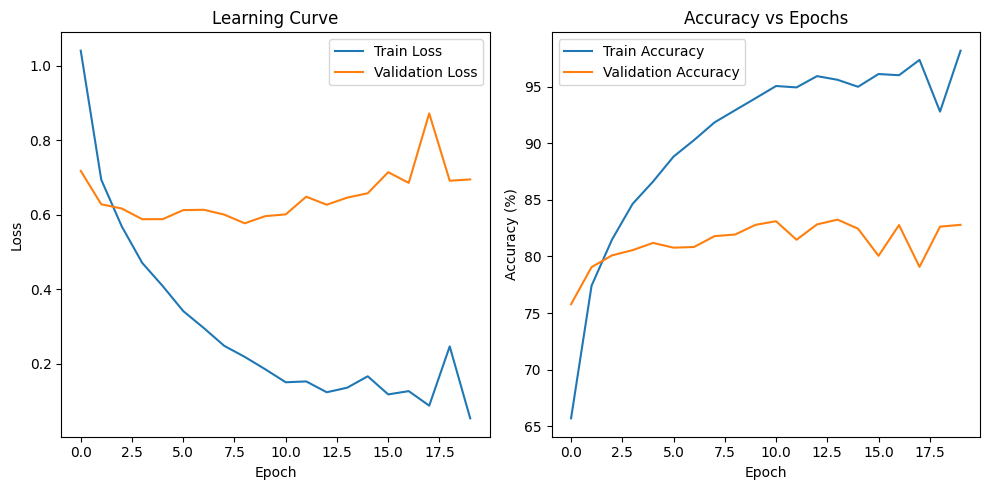

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Set up parameters
root = './data'
num_timesteps = 1
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet50 and modify for binary classification and 1-channel input
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(f"{model}")

# Modify the final fully connected layer for binary classification
num_classes = len(dataset.cifar.classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # 2 classes: circle and square
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        # Get only the first frame (t=0)
        images = sequences[:, 0, :, :, :]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            images = sequences[:, 0, :, :, :]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'resnet50_finetuned.pth')
print("Model weights saved to 'resnet50_finetuned.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

Files already downloaded and verified


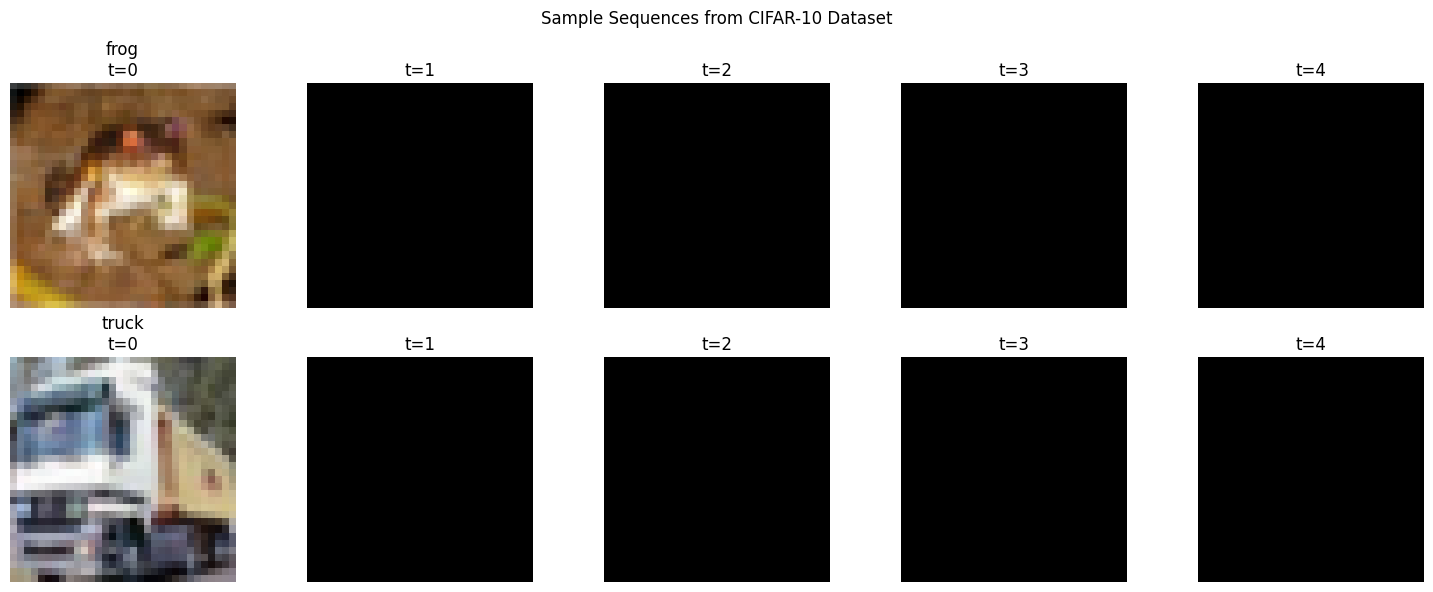

Accuracy on the test set: 96.02%


In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Sequences from CIFAR-10 Dataset")


test_dataset.dataset.num_timesteps = 5
for i in range(2):
    sequence, label = test_dataset.dataset[i]
    class_name = test_dataset.dataset.cifar.classes[label]
    
    for t in range(test_dataset.dataset.num_timesteps):
        if t == 0:
            # For the first frame, use color
            axes[i, t].imshow(sequence[t].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        else:
            # For subsequent frames, use grayscale
            axes[i, t].imshow(sequence[t][0], cmap='gray')
        axes[i, t].axis('off')
        axes[i, t].set_title(f"{class_name}\nt={t}" if t == 0 else f"t={t}")

plt.tight_layout()
plt.show()

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the saved model
model = models.resnet50()
num_classes = len(dataset.cifar.classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load('resnet50_finetuned.pth'))
model = model.to(device)
model.eval()

# Calculate accuracy on test set
correct = 0
total = 0

with torch.no_grad():
    for sequences, labels in test_loader:
        # Get only the first frame (t=0)
        images = sequences[:, 0, :, :, :]
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

# RESNET + LSTM

In [10]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=1):
        super(ResNetLSTM, self).__init__()
        
        # Load ResNet50 architecture (without weights)
        self.resnet = models.resnet50(weights=None)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        
        # Load your fine-tuned weights
        self.resnet.load_state_dict(torch.load('resnet50_finetuned.pth'))
        
        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Freeze ResNet50 layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Get the number of features from the last layer of ResNet50
        self.resnet_out_features = 2048  # This is the number of features output by ResNet50
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.resnet_out_features, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # Combine features
        self.combine_features = nn.Sequential(
            nn.Linear(self.resnet_out_features + hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Final classifier
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        # Extract features using ResNet50
        resnet_features = self.resnet(c_in)
        resnet_features = resnet_features.view(batch_size, timesteps, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(resnet_features)
        
        # Get the last output of LSTM
        lstm_last_out = lstm_out[:, -1, :]
        
        # Get the last ResNet features
        resnet_last_out = resnet_features[:, -1, :]
        
        # Combine LSTM and ResNet features
        combined = torch.cat((resnet_last_out, lstm_last_out), dim=1)
        combined_features = self.combine_features(combined)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)

# Example input
batch_size = 4
timesteps = 5
channels = 3
height = 224
width = 224
example_input = torch.randn(batch_size, timesteps, channels, height, width).to(device)
output = model(example_input)
print(f"Output shape: {output.shape}")

ResNetLSTM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

## Without Training LSTM Section

* without any delays
* accuracy is baseline

Files already downloaded and verified


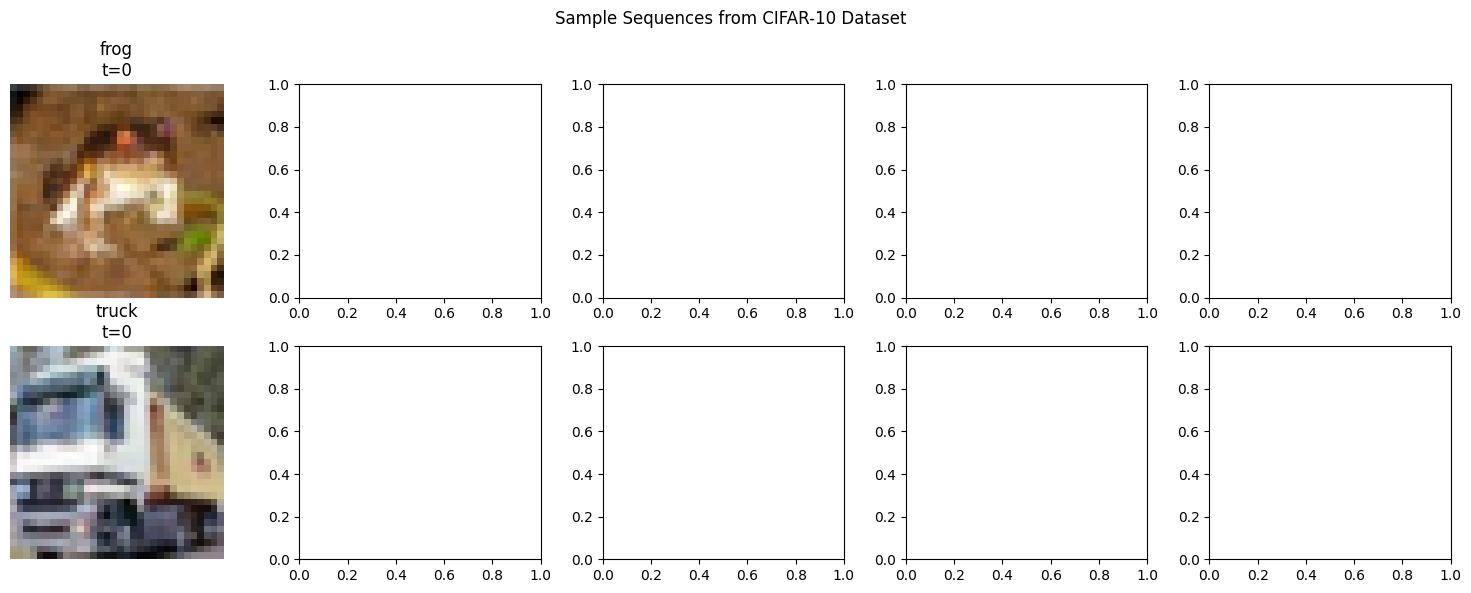

Accuracy on the test set: 6.22%


In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Sequences from CIFAR-10 Dataset")


test_dataset.dataset.num_timesteps = 1
for i in range(2):
    sequence, label = test_dataset.dataset[i]
    class_name = test_dataset.dataset.cifar.classes[label]
    
    for t in range(test_dataset.dataset.num_timesteps):
        if t == 0:
            # For the first frame, use color
            axes[i, t].imshow(sequence[t].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        else:
            # For subsequent frames, use grayscale
            axes[i, t].imshow(sequence[t][0], cmap='gray')
        axes[i, t].axis('off')
        axes[i, t].set_title(f"{class_name}\nt={t}" if t == 0 else f"t={t}")

plt.tight_layout()
plt.show()

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Calculate accuracy on test set
correct = 0
total = 0

with torch.no_grad():
    for sequences, labels in test_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

## Train only lstm part without adding delay

* Accuracy will be baseline when added delay

Files already downloaded and verified
Epoch [1/20], Train Loss: 0.2196, Train Acc: 94.78%, Val Loss: 0.1361, Val Acc: 96.22%
Epoch [2/20], Train Loss: 0.1775, Train Acc: 95.37%, Val Loss: 0.1365, Val Acc: 96.08%
Epoch [3/20], Train Loss: 0.1757, Train Acc: 95.40%, Val Loss: 0.1369, Val Acc: 96.12%
Epoch [4/20], Train Loss: 0.1999, Train Acc: 95.26%, Val Loss: 0.1381, Val Acc: 96.18%
Epoch [5/20], Train Loss: 0.1819, Train Acc: 95.55%, Val Loss: 0.1347, Val Acc: 96.40%
Epoch [6/20], Train Loss: 0.1812, Train Acc: 95.36%, Val Loss: 0.2913, Val Acc: 96.06%
Epoch [7/20], Train Loss: 0.1935, Train Acc: 95.44%, Val Loss: 0.2343, Val Acc: 96.12%
Epoch [8/20], Train Loss: 0.1808, Train Acc: 95.38%, Val Loss: 0.1434, Val Acc: 96.22%
Epoch [9/20], Train Loss: 0.1735, Train Acc: 95.41%, Val Loss: 0.1376, Val Acc: 96.06%
Epoch [10/20], Train Loss: 0.1794, Train Acc: 95.40%, Val Loss: 0.1385, Val Acc: 96.20%
Epoch [11/20], Train Loss: 0.1844, Train Acc: 95.53%, Val Loss: 0.1380, Val Acc: 96.18%
Epo

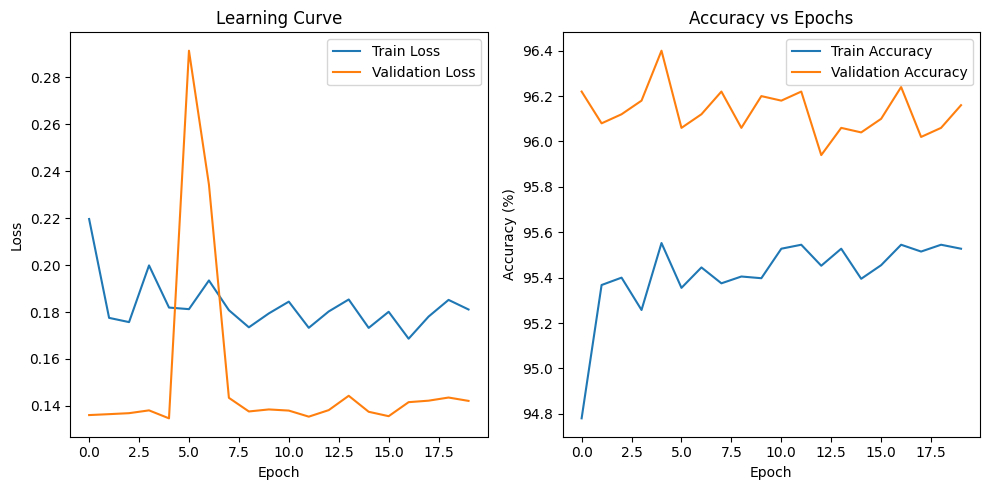

In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Set up parameters
root = './data'
num_timesteps = 1
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            images = sequences[:, :, :, :, :]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'resnetlstm_finetuned_without_delay.pth')
print("Model weights saved to 'resnetlstm_finetuned_without_delay.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

Files already downloaded and verified


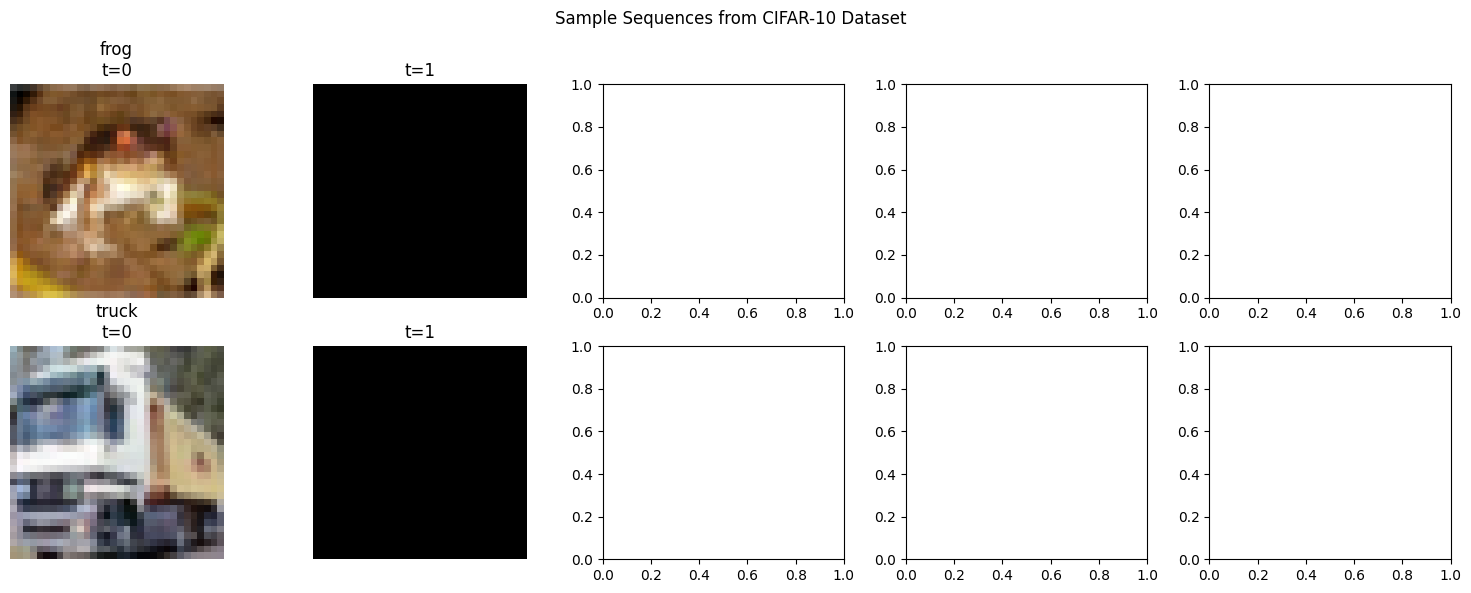

Accuracy on the test set: 9.80%


In [23]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Sequences from CIFAR-10 Dataset")


test_dataset.dataset.num_timesteps = 2
for i in range(2):
    sequence, label = test_dataset.dataset[i]
    class_name = test_dataset.dataset.cifar.classes[label]
    
    for t in range(test_dataset.dataset.num_timesteps):
        if t == 0:
            # For the first frame, use color
            axes[i, t].imshow(sequence[t].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        else:
            # For subsequent frames, use grayscale
            axes[i, t].imshow(sequence[t][0], cmap='gray')
        axes[i, t].axis('off')
        axes[i, t].set_title(f"{class_name}\nt={t}" if t == 0 else f"t={t}")

plt.tight_layout()
plt.show()

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('resnetlstm_finetuned_without_delay.pth'))
model = model.to(device)
model.eval()

# Calculate accuracy on test set
correct = 0
total = 0

with torch.no_grad():
    for sequences, labels in test_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

## Train LSTM part by adding 100ms delay to model

Files already downloaded and verified
Epoch [1/20], Train Loss: 0.7418, Train Acc: 78.24%, Val Loss: 0.6077, Val Acc: 80.62%
Epoch [2/20], Train Loss: 0.6556, Train Acc: 79.75%, Val Loss: 0.5852, Val Acc: 81.54%
Epoch [3/20], Train Loss: 0.6340, Train Acc: 80.01%, Val Loss: 0.5831, Val Acc: 80.98%
Epoch [4/20], Train Loss: 0.6195, Train Acc: 80.64%, Val Loss: 0.5856, Val Acc: 81.50%
Epoch [5/20], Train Loss: 0.6099, Train Acc: 80.86%, Val Loss: 0.5600, Val Acc: 81.90%
Epoch [6/20], Train Loss: 0.6032, Train Acc: 80.84%, Val Loss: 0.5776, Val Acc: 81.36%
Epoch [7/20], Train Loss: 0.5887, Train Acc: 81.19%, Val Loss: 0.5772, Val Acc: 81.30%
Epoch [8/20], Train Loss: 0.5873, Train Acc: 81.40%, Val Loss: 0.5626, Val Acc: 81.78%
Epoch [9/20], Train Loss: 0.5779, Train Acc: 81.39%, Val Loss: 0.5798, Val Acc: 81.64%
Epoch [10/20], Train Loss: 0.5804, Train Acc: 81.34%, Val Loss: 0.5741, Val Acc: 81.26%
Epoch [11/20], Train Loss: 0.5741, Train Acc: 81.64%, Val Loss: 0.5621, Val Acc: 81.78%
Epo

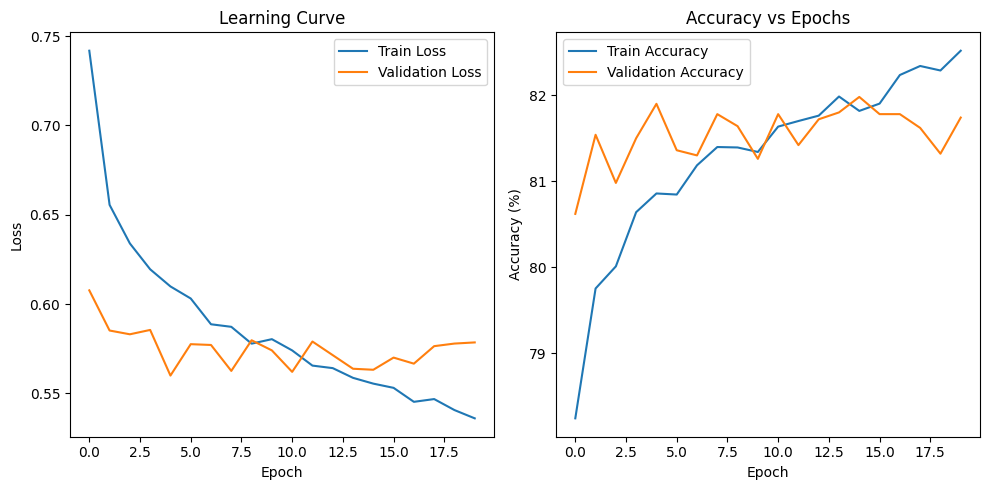

In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Set up parameters
root = './data'
num_timesteps = 4
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            images = sequences[:, :, :, :, :]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'resnetlstm_finetuned_100ms_delay.pth')
print("Model weights saved to 'resnetlstm_finetuned_100ms_delay.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

Files already downloaded and verified


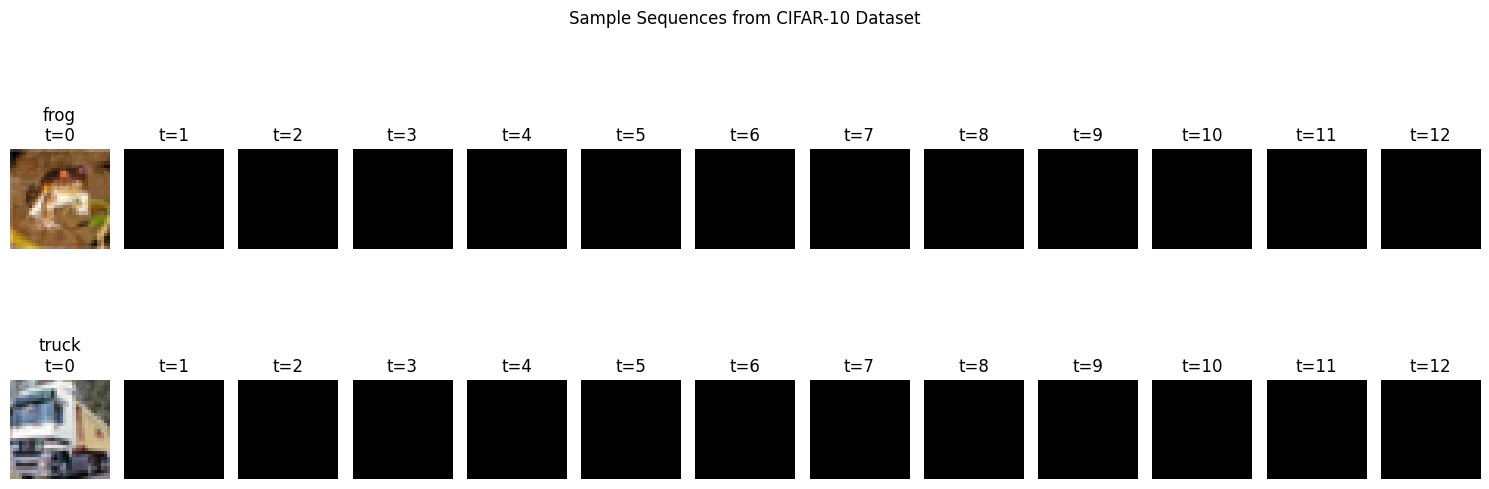

Accuracy on the test set: 33.06%


In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Plot some samples
fig, axes = plt.subplots(2, 13, figsize=(15, 6))
fig.suptitle("Sample Sequences from CIFAR-10 Dataset")


test_dataset.dataset.num_timesteps = 13
for i in range(2):
    sequence, label = test_dataset.dataset[i]
    class_name = test_dataset.dataset.cifar.classes[label]
    
    for t in range(test_dataset.dataset.num_timesteps):
        if t == 0:
            # For the first frame, use color
            axes[i, t].imshow(sequence[t].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        else:
            # For subsequent frames, use grayscale
            axes[i, t].imshow(sequence[t][0], cmap='gray')
        axes[i, t].axis('off')
        axes[i, t].set_title(f"{class_name}\nt={t}" if t == 0 else f"t={t}")

plt.tight_layout()
plt.show()

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('resnetlstm_finetuned_100ms_delay.pth'))
model = model.to(device)
model.eval()

# Calculate accuracy on test set
correct = 0
total = 0

with torch.no_grad():
    for sequences, labels in test_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

## Testing for different amound of delay

Files already downloaded and verified
Accuracy for 100ms delay: 85.30%
Accuracy for 400ms delay: 33.40%
Accuracy for 800ms delay: 14.24%
Accuracy for 1200ms delay: 11.56%


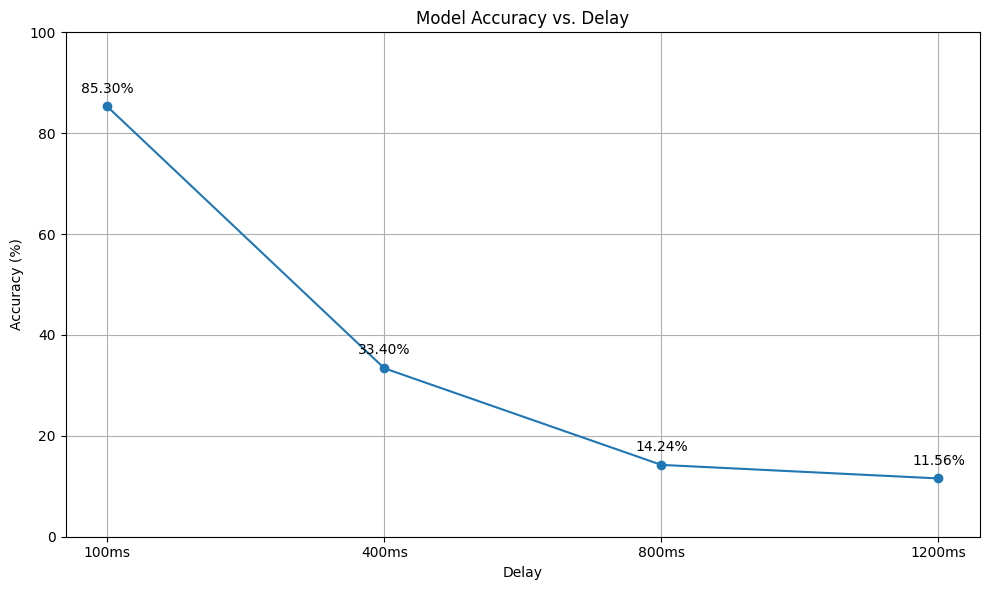

In [32]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def evaluate_accuracy(model, test_loader, device, num_frames):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            # Get only the first 'num_frames' frames
            images = sequences[:, :num_frames, :, :, :]
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('resnetlstm_finetuned_100ms_delay.pth'))
model = model.to(device)

# Dictionary of delays and corresponding frames
delay_frames = {"100ms": 4, "400ms": 13, "800ms": 25, "1200ms": 37}

# List to store results
results = []

# Evaluate accuracy for each delay
for delay, num_frames in delay_frames.items():
    # Adjust the dataset to use the correct number of frames
    test_dataset.dataset.num_timesteps = num_frames
    
    # Recreate the test loader with the updated dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate accuracy
    accuracy = evaluate_accuracy(model, test_loader, device, num_frames)
    results.append((delay, accuracy))
    print(f'Accuracy for {delay} delay: {accuracy:.2f}%')

# Sort results by delay (assuming delays are in ascending order)
results.sort(key=lambda x: int(x[0][:-2]))  # Sort by delay value

# Prepare data for plotting
delays = [r[0] for r in results]
accuracies = [r[1] for r in results]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(delays, accuracies, marker='o')
plt.title('Model Accuracy vs. Delay')
plt.xlabel('Delay')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%
plt.grid(True)

# Add value labels on the plot
for i, accuracy in enumerate(accuracies):
    plt.annotate(f'{accuracy:.2f}%', (delays[i], accuracy), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## Train LSTM part by adding 800ms delay to model

Files already downloaded and verified
Epoch [1/20], Train Loss: 2.3058, Train Acc: 10.05%, Val Loss: 2.3058, Val Acc: 9.44%
Epoch [2/20], Train Loss: 2.1023, Train Acc: 19.55%, Val Loss: 1.8133, Val Acc: 34.04%
Epoch [3/20], Train Loss: 1.6817, Train Acc: 43.19%, Val Loss: 1.5130, Val Acc: 50.20%
Epoch [4/20], Train Loss: 1.5552, Train Acc: 49.32%, Val Loss: 1.4906, Val Acc: 51.30%
Epoch [5/20], Train Loss: 1.5076, Train Acc: 50.85%, Val Loss: 1.4333, Val Acc: 53.50%
Epoch [6/20], Train Loss: 1.4693, Train Acc: 52.06%, Val Loss: 1.4236, Val Acc: 53.20%
Epoch [7/20], Train Loss: 1.4617, Train Acc: 52.55%, Val Loss: 1.4033, Val Acc: 53.38%
Epoch [8/20], Train Loss: 1.4553, Train Acc: 52.55%, Val Loss: 1.3770, Val Acc: 54.54%
Epoch [9/20], Train Loss: 1.4331, Train Acc: 53.23%, Val Loss: 1.4065, Val Acc: 53.26%
Epoch [10/20], Train Loss: 1.4281, Train Acc: 53.52%, Val Loss: 1.3927, Val Acc: 53.96%
Epoch [11/20], Train Loss: 1.4197, Train Acc: 53.33%, Val Loss: 1.3797, Val Acc: 54.76%
Epoc

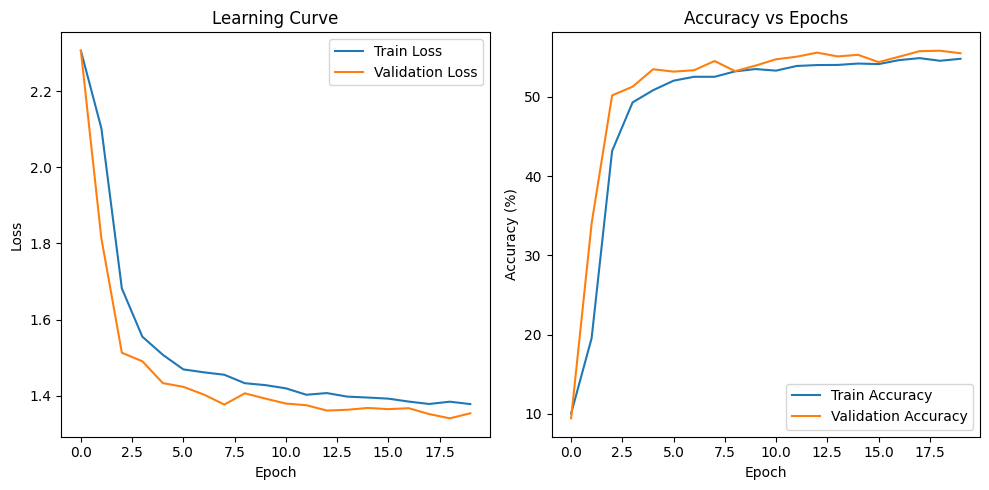

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Set up parameters
root = './data'
num_timesteps = 25
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            images = sequences[:, :, :, :, :]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'resnetlstm_finetuned_800ms_delay.pth')
print("Model weights saved to 'resnetlstm_finetuned_800ms_delay.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

Files already downloaded and verified
Accuracy for 100ms delay: 26.12%
Accuracy for 400ms delay: 55.92%
Accuracy for 800ms delay: 57.84%
Accuracy for 1200ms delay: 54.70%


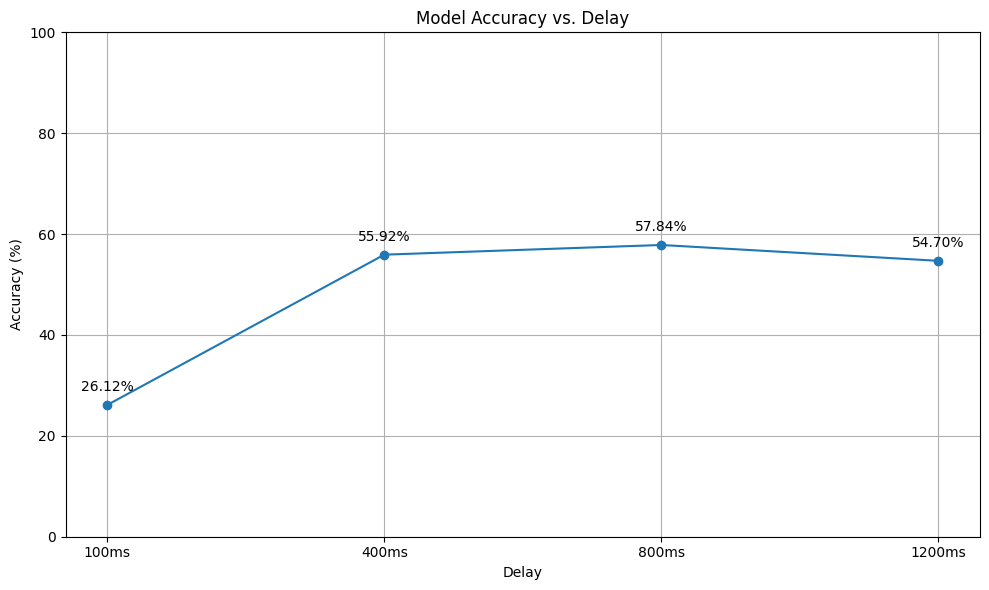

In [12]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def evaluate_accuracy(model, test_loader, device, num_frames):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            # Get only the first 'num_frames' frames
            images = sequences[:, :num_frames, :, :, :]
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('resnetlstm_finetuned_800ms_delay.pth'))
model = model.to(device)

# Dictionary of delays and corresponding frames
delay_frames = {"100ms": 4, "400ms": 13, "800ms": 25, "1200ms": 37}

# List to store results
results = []

# Evaluate accuracy for each delay
for delay, num_frames in delay_frames.items():
    # Adjust the dataset to use the correct number of frames
    test_dataset.dataset.num_timesteps = num_frames
    
    # Recreate the test loader with the updated dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate accuracy
    accuracy = evaluate_accuracy(model, test_loader, device, num_frames)
    results.append((delay, accuracy))
    print(f'Accuracy for {delay} delay: {accuracy:.2f}%')

# Sort results by delay (assuming delays are in ascending order)
results.sort(key=lambda x: int(x[0][:-2]))  # Sort by delay value

# Prepare data for plotting
delays = [r[0] for r in results]
accuracies = [r[1] for r in results]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(delays, accuracies, marker='o')
plt.title('Model Accuracy vs. Delay')
plt.xlabel('Delay')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%
plt.grid(True)

# Add value labels on the plot
for i, accuracy in enumerate(accuracies):
    plt.annotate(f'{accuracy:.2f}%', (delays[i], accuracy), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## Train LSTM part by adding 400ms delay to model

Files already downloaded and verified
Epoch [1/20], Train Loss: 1.5840, Train Acc: 46.03%, Val Loss: 1.3100, Val Acc: 58.62%
Epoch [2/20], Train Loss: 1.3173, Train Acc: 59.15%, Val Loss: 1.2048, Val Acc: 62.12%
Epoch [3/20], Train Loss: 1.2605, Train Acc: 60.30%, Val Loss: 1.1926, Val Acc: 62.10%
Epoch [4/20], Train Loss: 1.2355, Train Acc: 60.73%, Val Loss: 1.1536, Val Acc: 62.24%
Epoch [5/20], Train Loss: 1.2132, Train Acc: 61.57%, Val Loss: 1.1558, Val Acc: 62.20%
Epoch [6/20], Train Loss: 1.1991, Train Acc: 61.75%, Val Loss: 1.1463, Val Acc: 63.04%
Epoch [7/20], Train Loss: 1.1786, Train Acc: 62.29%, Val Loss: 1.1271, Val Acc: 64.06%
Epoch [8/20], Train Loss: 1.1754, Train Acc: 62.35%, Val Loss: 1.1248, Val Acc: 63.56%
Epoch [9/20], Train Loss: 1.1686, Train Acc: 62.50%, Val Loss: 1.1176, Val Acc: 62.96%
Epoch [10/20], Train Loss: 1.1606, Train Acc: 62.73%, Val Loss: 1.1105, Val Acc: 63.88%
Epoch [11/20], Train Loss: 1.1482, Train Acc: 62.94%, Val Loss: 1.0968, Val Acc: 63.70%
Epo

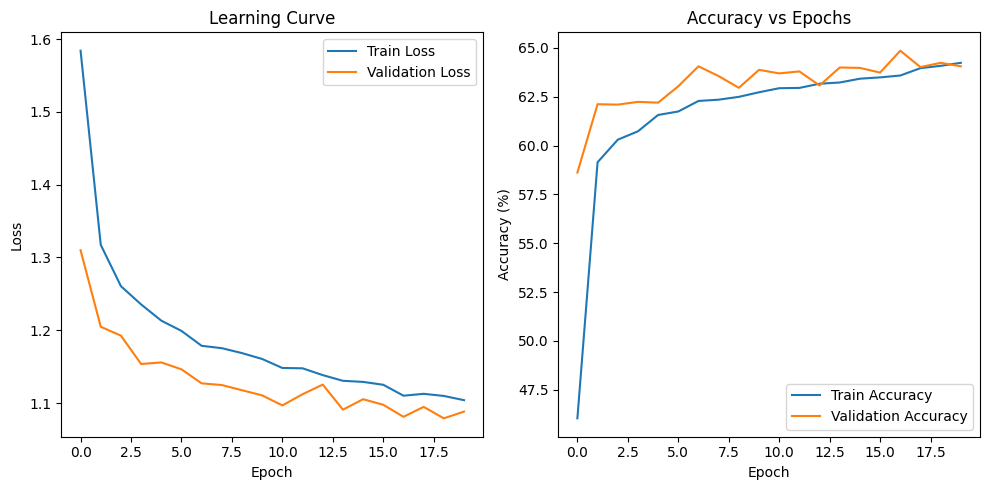

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Set up parameters
root = './data'
num_timesteps = 13
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        # Get only the first frame (t=0)
        images = sequences[:, :, :, :, :]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            images = sequences[:, :, :, :, :]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'resnetlstm_finetuned_400ms_delay.pth')
print("Model weights saved to 'resnetlstm_finetuned_400ms_delay.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

Files already downloaded and verified
Accuracy for 100ms delay: 59.56%
Accuracy for 400ms delay: 66.58%
Accuracy for 800ms delay: 42.38%
Accuracy for 1200ms delay: 14.40%


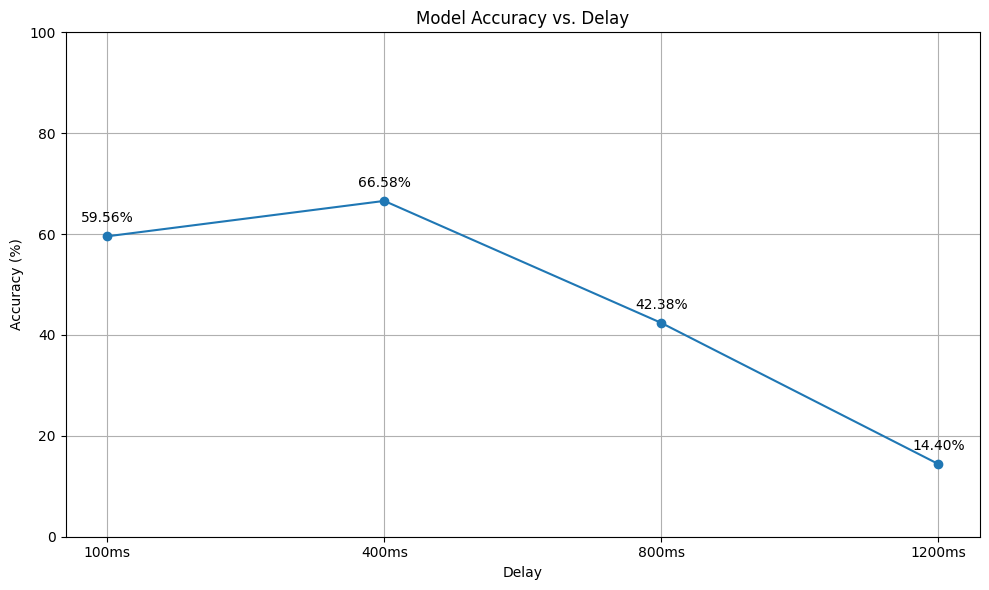

In [15]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def evaluate_accuracy(model, test_loader, device, num_frames):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            # Get only the first 'num_frames' frames
            images = sequences[:, :num_frames, :, :, :]
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32

# Set up parameters
root = './data'
num_timesteps = 1

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, int(val_size / 2), int(val_size / 2)])

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('resnetlstm_finetuned_400ms_delay.pth'))
model = model.to(device)

# Dictionary of delays and corresponding frames
delay_frames = {"100ms": 4, "400ms": 13, "800ms": 25, "1200ms": 37}

# List to store results
results = []

# Evaluate accuracy for each delay
for delay, num_frames in delay_frames.items():
    # Adjust the dataset to use the correct number of frames
    test_dataset.dataset.num_timesteps = num_frames
    
    # Recreate the test loader with the updated dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate accuracy
    accuracy = evaluate_accuracy(model, test_loader, device, num_frames)
    results.append((delay, accuracy))
    print(f'Accuracy for {delay} delay: {accuracy:.2f}%')

# Sort results by delay (assuming delays are in ascending order)
results.sort(key=lambda x: int(x[0][:-2]))  # Sort by delay value

# Prepare data for plotting
delays = [r[0] for r in results]
accuracies = [r[1] for r in results]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(delays, accuracies, marker='o')
plt.title('Model Accuracy vs. Delay')
plt.xlabel('Delay')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%
plt.grid(True)

# Add value labels on the plot
for i, accuracy in enumerate(accuracies):
    plt.annotate(f'{accuracy:.2f}%', (delays[i], accuracy), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()